In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from typing import Callable, Tuple
from scipy.integrate import solve_ivp

In [2]:
class Isoterm:
    
    @staticmethod
    def langmuir(Ce: float, qml: float, Kl: float):
        return qml*Kl*Ce/(1+Kl*Ce)
    
    @staticmethod
    def freundlich(Ce: float, Kf: float, nf: float):
        return Kf*Ce**(1/nf)
    
    @staticmethod
    def plot_isoterm(isoterm: Callable, dict_isoterm: dict, Ce:float, n_point=100, x_unit:str=None, y_unit: str=None):
        Ce = np.linspace(0,Ce,n_point)
        q = isoterm(Ce, **dict_isoterm)
        
        x_label = "Concentração"
        if x_unit:
            x_label = "%s (%s)" %(x_label, x_unit)
        y_label = "Capacidade de Adsorção"
        if y_unit:
            y_label = "%s (%s)" %(y_label, y_unit)
            
        plt.plot(Ce, q)          
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title("Isoterma de %s" % isoterm.__name__)
        plt.grid()

In [3]:
class Kinetics:
    
    @staticmethod
    def first_order(q, qe, k):
        return k*(qe- q)
    
    @staticmethod
    def second_order(q, qe, k):
        return k*(qe- q)**2
    
    @staticmethod
    def plot_kinetics(kinetics: Callable, dict_kinetics: dict, time:float, n_point=100, x_unit:str=None, y_unit: str=None,
                     x_label: str='Tempo', y_label: str = 'Capacidade de Adsorção', title:str=None, ax=None):
        res = solve_ivp(lambda t,y : kinetics(y[0], **dict_kinetics), (0,time), [0], max_step=0.01)
        
#         x_label = "Tempo"
        if x_unit:
            x_label = "%s (%s)" %(x_label, x_unit)
#         y_label = "Capacidade de Adsorção"
        if y_unit:
            y_label = "%s (%s)" %(y_label, y_unit)
        
        ax = ax or plt.gca()
        ax.plot(res.t, res.y[0])          
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        name = kinetics.__name__.split("_")[0]
        name = Kinetics.__translate(name)
        if not title==None:
            plt.title(title)
        else:
            plt.title("Cinética de pseudo %s ordem" % name)
        ax.grid()
        
    @staticmethod
    def __translate(name: str):
        dict_tranlate={"first": "primeira", "second": "segunda"}
        response = dict_tranlate[name]
        return response

In [4]:
class Tank:
    def __init__(self, isoterm: Callable, dict_isoterm: dict, knetics: Callable, dict_knetics: dict):
        self.__isoterm = isoterm
        self.__dict_isoterm = dict_isoterm
        self.__knetics = knetics
        self.__dict_knetics = dict_knetics
        self.__concentration = None
        self.__adsorption_capacity = None
        self.__time = None
        
    
    @property
    def isoterm(self):
        return self.__isoterm
    
    @isoterm.setter
    def isoterm(self, new_isoterm: Callable):
        self.__concentration = None
        self.__adsorption_capacity = None
        self.__time = None
        self.__isoterm = new_isoterm
    
    @property
    def dict_isoterm(self):
        return self.__dict_isoterm
    
    @dict_isoterm.setter
    def dict_isoterm(self, new_dict: dict):
        self.__concentration = None
        self.__adsorption_capacity = None
        self.__time = None
        
        self.__dict_isoterm = new_dict
        
    @property
    def knetics(self):
        return self.__knetics
    
    @knetics.setter
    def knetics(self, new_knetics: Callable):
        self.__concentration = None
        self.__adsorption_capacity = None
        self.__time = None
        self.__knetics = new_knetics
        
    @property
    def dict_knetics(self):
        return self.__dict_knetics
    
    @dict_knetics.setter
    def dict_knetics(self, new_dict: dict):
        self.__concentration = None
        self.__adsorption_capacity = None
        self.__time = None
        
        self.__dict_knetics = new_dict
    
    @property
    def concentration(self):
        return self.__concentration
    
    @property
    def adsorption_capacity(self):
        return self.__adsorption_capacity
    
    @property
    def time(self):
        return self.__time
    
    @staticmethod
    def __edo(t, y, isoterm, dict_isoterm, knetics, dict_knetics, mass_adsorption, volume) -> list:
        c = y[0]
        q = y[1]
        qe = isoterm(c,**dict_isoterm)
        dq = knetics(q, qe, **dict_knetics)
        dc = -dq*mass_adsorption/volume
    
        return [dc, dq]
    
    def run(self, concentration: float, mass_adsorption: float, 
                              volume: float, time: float, inplace=True)-> Tuple[np.array, np.array]:
        res = solve_ivp(Tank.__edo, (0,time), (concentration, 0), max_step=0.0125, method='RK45',
                        args=(self.isoterm, self.dict_isoterm, self.knetics, self.dict_knetics, mass_adsorption, volume))
        if inplace:
            self.__concentration = res.y[0]
            self.__adsorption_capacity = res.y[1]
            self.__time = res.t
        
        return res.t, res.y[0]
    
    def plot_concentration(self, x_unit:str= None, y_unit:str=None):
        plt.plot(self.time,self.concentration)
        x_label = "Tempo"
        if x_unit:
            x_label = "%s (%s)" % (x_label, x_unit)
        y_label =  "Concentração"   
        if y_unit:
            y_label = "%s (%s)" % (y_label, y_unit)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title("Concentração vs Tempo")
        plt.grid()
        
    def plot_adsorption_capacity(self, x_unit:str= None, y_unit:str=None):
        plt.plot(self.time,self.__adsorption_capacity)
        x_label = "Tempo"
        if x_unit:
            x_label = "%s (%s)" % (x_label, x_unit)
        y_label =  "Capacidade de Adsorção"   
        if y_unit:
            y_label = "%s (%s)" % (y_label, y_unit)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title("Capacidade de Adsorção vs Tempo")
        plt.grid()
        
    def plot_recovery(self, x_unit:str= None):
        recovery = 1 - self.concentration/self.concentration[0]
        plt.plot(self.time,recovery)
        x_label = "Tempo"
        if x_unit:
            x_label = "%s (%s)" % (x_label, x_unit)
        plt.xlabel(x_label)
        plt.ylabel("Porcentagem de Recuperação")
        plt.title("Recuperação vs Tempo")
        plt.grid()

In [5]:
def my_problem(time: float, mass_adsorption: float, vazao:float = 3.5, adsorvent: str = 'biomass'):
    #Time -> Horas
    #Mass_Adsorption ->
    #vazão -> m³/s
    concentration = 0.24676 # -> g/m3 
    mim_recovery = 0.8
    
    if adsorvent == 'biomass':
        isoterm_dict = isoterm_dict_biomass # -> g/kg
        kinetics_dic = kinetics_dic_biomass
        kinetics = Kinetics.second_order
    else:
        isoterm_dict = isoterm_dict_coal # -> g/kg
        kinetics_dic = kinetics_dic_coal
        kinetics = Kinetics.second_order
    
        
    tank = Tank(Isoterm.langmuir, isoterm_dict, kinetics, kinetics_dic)
    
    t, concentration = tank.run(concentration=concentration, mass_adsorption=mass_adsorption,
                                                      volume=1, time=time, inplace=False)
    
    
    recovery = 1 - concentration[-1]/concentration[0]
    if recovery<mim_recovery:
        recovery = 0
    if recovery>1:
        print('Recovery %s mass: %s time %s'%(recovery, mass_adsorption, time))
    
    return recovery

In [6]:
isoterm_dict_coal = {'qml': 82.8, 'Kl': 522} # -> g/kg
kinetics_dic_coal = {'k': 0.0009*60}
isoterm_dict_biomass = {'qml': 1/0.061, 'Kl': 0.084} # -> g/kg
kinetics_dic_biomass = {'k': .282*60}

GRÁFICOS DE REMOÇÃO

Recovery 189.00339599916666 mass: 0.013400000000000025 time 0.07590000000000074


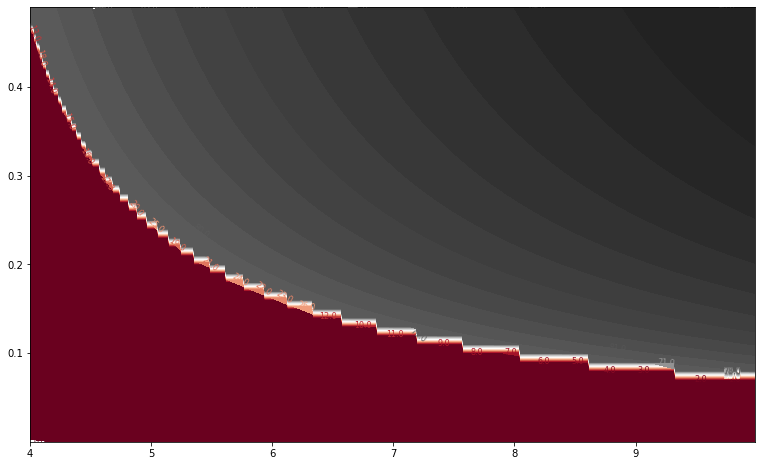

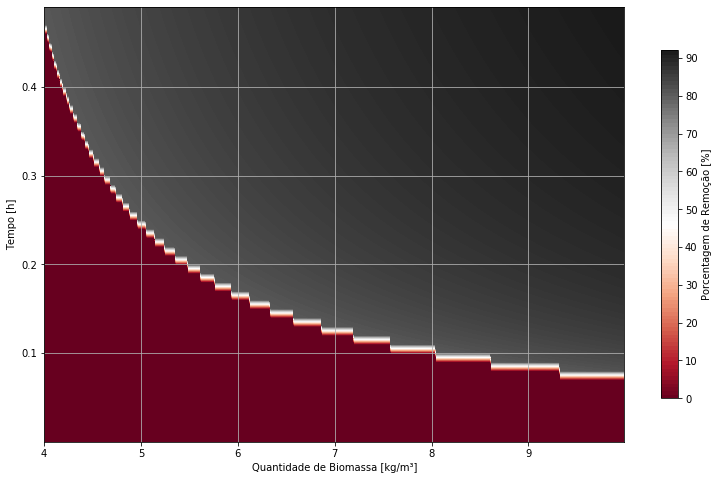

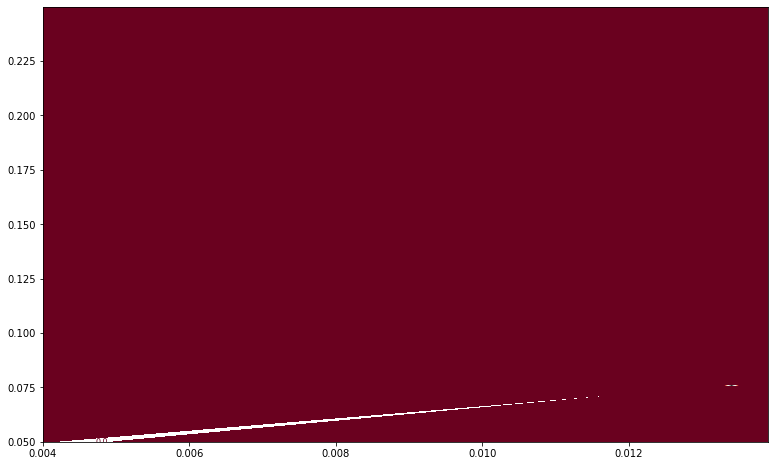

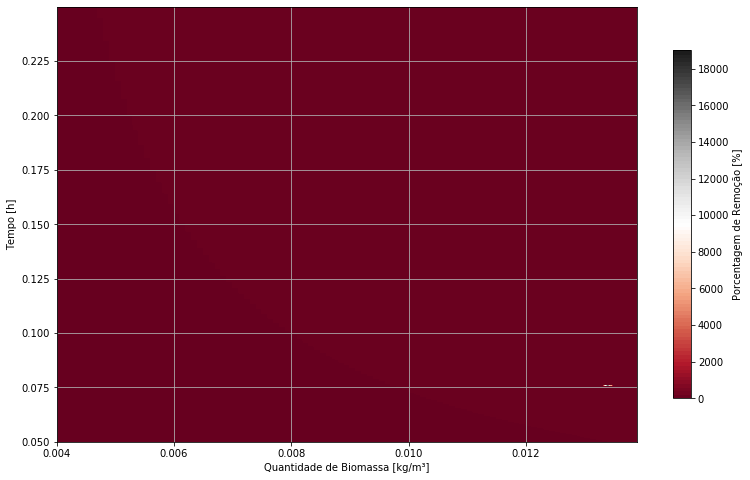

In [11]:
for adsorvent in ['biomass', 'coal']:
    #LIMITES DO GRÁFICO
    if adsorvent=='biomass':
        mass_adsorptions = np.arange(4,10,0.01)
        times = np.arange(0.0001, 0.5, 0.01)
    else:
        mass_adsorptions = np.arange(0.004,0.014,0.0001)
        times = np.arange(0.05, 0.25, 0.0001)
                
    MASS = np.array([[]])
    TIME = np.array([[]])
    REMOVE = np.array([[]])
    i = 0
    
    #GERA OS DADOS
    for time in times:
        time_array = np.array([])
        mass_adsorption_array = np.array([])
        removes = np.array([])
        for mass_adsorption in mass_adsorptions:
            remove = my_problem(time, mass_adsorption, adsorvent=adsorvent)
            time_array =  np.append(time_array, time)
            mass_adsorption_array =  np.append(mass_adsorption_array, mass_adsorption)
            removes = np.append(removes, remove)

        if i==0:
            MASS = np.array([mass_adsorption_array])
            TIME = np.array([time_array])
            REMOVE = np.array([removes])
        else:
            TIME = np.append(TIME, [time_array], axis=0)
            MASS = np.append(MASS, [mass_adsorption_array], axis=0)
            REMOVE = np.append(REMOVE, [removes], axis=0)
        i += 1

    # GERA AS IMAGENS
    
    fig, ax = plt.subplots(figsize=(13,8))
    contours=ax.contourf(mass_adsorptions,times,REMOVE*100,100, cmap='RdGy')
    fig, ax = plt.subplots(figsize=(13,8))
    plt.contourf(mass_adsorptions,times,REMOVE, 1000, cmap='RdGy')
    plt.colorbar(contours, shrink=0.80,label="Porcentagem de Remoção [%]")
    plt.clabel(contours, inline=True, fontsize=8, fmt='%.1f')
    plt.xlabel('Quantidade de Biomassa [kg/m³]')
    plt.ylabel('Tempo [h]')
    # plt.title('Porcentagem em função do tempo e quantidade de biomassa ')
    plt.grid()
    plt.savefig(f'images/{adsorvent}_remotion_graph.png')

GRÁFICOS DE ISOTERMA E CINÉTICA

In [81]:
Ce = np.linspace(0,0.6,1000)
q_coal = Isoterm.langmuir(Ce, **isoterm_dict_coal)
q_biomass = Isoterm.langmuir(Ce, **isoterm_dict_biomass)

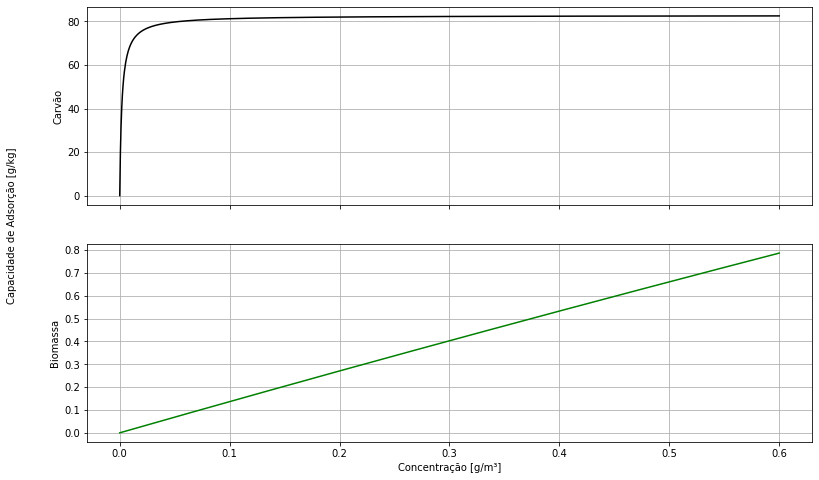

In [51]:
fig, axs = plt.subplots(2, sharex=True, figsize=(13,8))
# fig.suptitle('Isoterma para Carvão Ativado e a Biomassa')
fig.text(0.04, 0.5, 'Capacidade de Adsorção [g/kg]', va='center', rotation='vertical')
axs[0].plot(Ce, q_coal, 'k')
axs[0].set(ylabel='Carvão')
axs[0].grid()
axs[1].plot(Ce, q_biomass, 'g')
axs[1].set(ylabel='Biomassa', xlabel='Concentração [g/m³]')
axs[1].grid()
plt.savefig('images/isoterms_comparation.png')

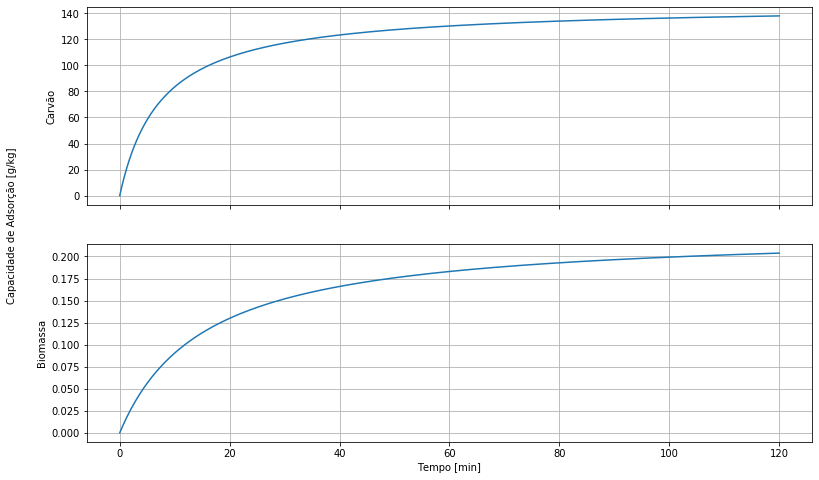

In [22]:
dict_biomass = kinetics_dic_biomass.copy()
dict_coal = kinetics_dic_coal.copy()
# VOLTANDO A UNIDADE DE k PARA MINUTO

dict_coal['k'] = dict_coal['k']/60
dict_biomass['k'] = dict_biomass['k']/60

# ADICIONANDO PARAMETROS DE qe PRESENTES NOS SHERIF E GE
dict_biomass['qe'] = 0.23
dict_coal['qe'] = 146.67

fig, axs = plt.subplots(2, sharex=True, figsize=(13,8))
# fig.suptitle('Cinética para Carvão Ativado e a Biomassa')
fig.text(0.04, 0.5, 'Capacidade de Adsorção [g/kg]', va='center', rotation='vertical')
axs[0].set(ylabel='Carvão')
Kinetics.plot_kinetics(Kinetics.second_order, dict_coal, 120, y_label='', ax=axs[0], title='', x_label='Tempo [min]')
Kinetics.plot_kinetics(Kinetics.second_order, dict_biomass, 120, y_label='', ax=axs[1], title='', x_label='Tempo [min]')
axs[1].set(ylabel='Biomassa')
plt.savefig('images/kinetics_comparation.png')

GRÁFICO DE VAZÃO

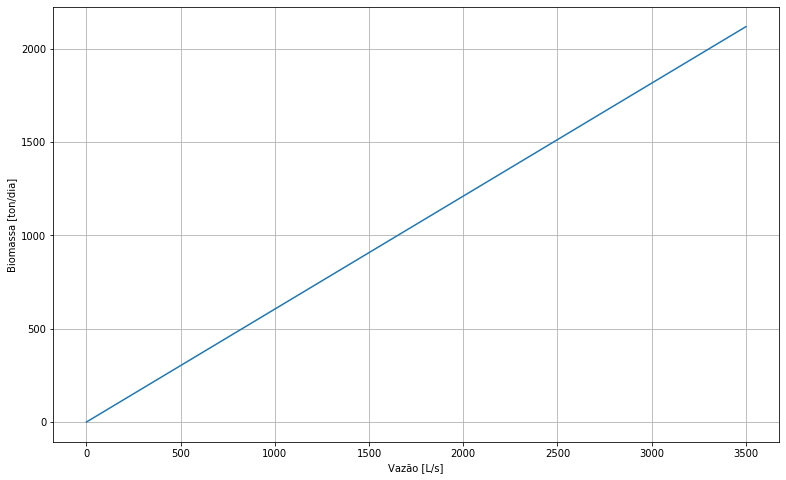

In [23]:
#GERO OS DADOS
vazao = np.linspace(0,3500, 5000)
biomassa_por_volume = 7
biomass_quantity = vazao*3.600*24*biomassa_por_volume/1000

#GERA O GRÁFICO
plt.figure(figsize=(13,8))
plt.plot(vazao, biomass_quantity)
# plt.title('Biomassa Necessária em um dia por Vazão Tratada')
plt.xlabel('Vazão [L/s]')
plt.ylabel('Biomassa [ton/dia]')
plt.grid(which='major')
plt.savefig('images/biomass_flow.png')